# Leeds property prices

This notebook explores property prices in Leeds. It is a rough and ready and is subject to countless provisos, which include the following:

- Number of bedrooms data is missing. This is presumably a strong predictor of price. I didn't attempt to find or impute this information (e.g. via Zoopla or Rightmove APIs, or scraping).
- No proper analytic investigation (from first principles) or numerical investigation (goodness of fit) of the correct distribution for the hypothesis tests used for price change comparisons is attempted.
- An approach based on fundamental understanding of the basic ontology of the system is always preferable to blindly-applied frequentist hypothesis tests in my firm opinion. Whatever. Brute force stats is fun!
- No attempt is made to account for causal relationships between variables.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

np.set_printoptions(edgeitems=30, linewidth=100000)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# force full-width display if viewed in Chrome browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Download UK Land Registry price-paid data and create bigquery dataset

In [2]:
#   # download data to the VM from source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
#   !wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv
#   
#   # move to gcp bucket
#   !gsutil mv pp-complete.csv gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv
#          
#   # make bigquery database called 'housing'
#   !bq mk housing
#   
#   # create table called 'pricepaid' in housing database
#   !bq load --source_format=CSV \
#   housing.pricepaid gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv \
#   trans_id:STRING,price:INTEGER,date:STRING,postcode:STRING,type:STRING,newbuild:STRING,tenure:STRING,paon:STRING,saon:STRING,street:STRING,locality:STRING,town_city:STRING,district:STRING,county:STRING,ppd_type:STRING,record_status:STRING

In [3]:
# !wget https://www.freemaptools.com/download/full-uk-postcodes/ukpostcodes.zip
# !unzip ukpostcodes.zip
# postcodes = pd.read_csv('ukpostcodes.csv')

In [4]:
# https://www.freemaptools.com/download/full-uk-postcodes/ukpostcodes.zip

In [5]:
#   !bq load --source_format=CSV \
#   housing.pricepaid gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv \
#   trans_id:STRING,price:INTEGER,date:STRING,postcode:STRING,type:STRING,newbuild:STRING,tenure:STRING,paon:STRING,saon:STRING,street:STRING,locality:STRING,town_city:STRING,district:STRING,county:STRING,ppd_type:STRING,record_status:STRING

## 2. Query data (Leeds only)

In [2]:
%%bigquery df

SELECT * FROM housing.pricepaid
WHERE town_city = 'LEEDS'

Downloading: 100%|██████████| 305373/305373 [00:02<00:00, 137328.14rows/s]


## 3. Inspect dataframe

In [3]:
df

,trans_id,price,date,postcode,type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status
0,{AC07BBD0-A011-0445-E053-6C04A8C01E31},382500,2020-05-01 00:00,LS17 8GD,D,N,F,6,,BRANDON CLOSE,,LEEDS,LEEDS,WEST YORKSHIRE,A,A
1,{3BD53B87-79D7-4303-B999-6C57ACE3C713},492000,2006-12-15 00:00,LS17 9BE,D,N,F,25,,FIRST AVENUE,BARDSEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A
2,{4719B1E6-26CC-4F18-818B-73A1A19D5054},167950,2006-11-29 00:00,LS5 3NW,D,N,F,11,,VESPER COURT,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A
3,{CD1BB411-D90D-4F60-83FC-97B03877A38F},125000,2003-04-23 00:00,LS25 2DD,D,N,F,74,,COTSWOLD DRIVE,GARFORTH,LEEDS,LEEDS,WEST YORKSHIRE,A,A
4,{FBBB1D15-5453-4493-A329-D06B7459201A},240000,1998-07-15 00:00,LS6 4EE,D,N,F,41,,GROVE ROAD,HEADINGLEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305368,{2A289E9D-C89D-CDC8-E050-A8C063054829},96995,2001-09-07 00:00,LS25 5PZ,T,Y,F,7,,MULBERRY COURT,SOUTH MILFORD,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305369,{5CF9903C-52BF-7F13-E053-6C04A8C074B1},150000,2017-09-22 00:00,LS25 5PN,T,N,F,3,,CHESTNUT GREEN,MONK FRYSTON,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305370,{B2E0DEBE-62AA-448E-8D06-1CC7DC6320EF},152000,2011-10-28 00:00,LS25 5AR,T,N,F,7A,,LOW STREET,SOUTH MILFORD,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305371,{5F54B81E-2FDB-2B45-E053-6B04A8C01FB0},106000,2017-06-30 00:00,LS25 6GE,T,N,F,43,,BRUNSWICK CRESCENT,SHERBURN IN ELMET,LEEDS,SELBY,NORTH YORKSHIRE,B,A


In [42]:
# how many unique values are in each column?
df.nunique()

trans_id             305169
price                 12150
date                   7747
postcode              14094
property_type             5
newbuild                  2
tenure                    3
paon                   6153
saon                   2330
street                 8963
locality                120
town_city                 1
district                 11
county                    4
ppd_type                  2
record_status             1
postcode_area             1
postcode_district        25
postcode_sector          10
postcode_unit           387
dtype: int64

In [5]:
# check data types
df.dtypes

trans_id         object
price             int64
date             object
postcode         object
type             object
newbuild         object
tenure           object
paon             object
saon             object
street           object
locality         object
town_city        object
district         object
county           object
ppd_type         object
record_status    object
dtype: object

## 4. Pre-processing / clean-up

### 1. Postcode

In [6]:
# Some rows have missing postcodes
len(df[df['postcode'] == ''])

204

In [7]:
# Check for null entries in postcode column
len(df[df['postcode'].isnull()])

0

In [8]:
# Discard rows with empty string postcodes 
df = df[df['postcode'] != '']

In [9]:
# Check that all postcodes have space
len(df[df['postcode'].str.contains(' ')]) == len(df)

True

In [10]:
# Break down postcodes into components: area, district, sector ,and unit. 
def get_postcode_components(postcode):
    
    """
    Returns part of all of a postcode string resolved into area, district, sector or unit. 
    
    UK postcodes take any of the following formats, where A denotes alphabetical
    and N denotes numeric:
    
    AN NAA 
    ANN NAA
    AAN NAA
    AANN NAA
    ANA NAA
    AANA NAA
    
    (source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/611951/Appendix_C_ILR_2017_to_2018_v1_Published_28April17.pdf)
    
    - Area is the leftmost substring of alpha characters until (and excluding) a numeric character .Format: A or AA.
    - District is the substring commencing with numeric after the area, and before the space. Format: N, NN, or NA.
    - Sector is the first numeric character after the space. Format: N.
    - Unit is the rightmost substring. Format: AA.
   
    e.g.:
    >> get_postcode_component('RG40 2WD', component='sector')
    >> 2   
    
    e.g. 2:
    >> get_postcode_component('EC1A 3HX', component='area')
    >> EC
    
    e.g. 3:
    >> get_postcode_component('EC1A 3HX', component='district')
    >> 1A
    """
    
    # e.g. EC1A 3HX
    area_and_district = postcode.split(' ')[0] # EC1A
    sector_and_unit = postcode.split(' ')[1] # 3HX
        
    for index, char in enumerate(area_and_district):
        if char.isnumeric():
            area = area_and_district[:index] # EC
            district = area_and_district[index:] #1A
            break

    for index, char in enumerate(sector_and_unit):
        if char.isnumeric():
            unit = sector_and_unit[index+1:] # 3
            sector = sector_and_unit[:index+1] # HX
            break
    
    return dict({'area':area,
                 'district':district,
                 'sector':sector,
                 'unit':unit}
               )


# tests
test_postcodes = ['A1 2BC', 'A12 3BC', 'AB1 2BC', 'AB12 3CD', 'A1B 2BC', 'AB1C 2DE']
for postcode in test_postcodes:
    print(postcode, get_postcode_components(postcode))

A1 2BC {'area': 'A', 'district': '1', 'sector': '2', 'unit': 'BC'}
A12 3BC {'area': 'A', 'district': '12', 'sector': '3', 'unit': 'BC'}
AB1 2BC {'area': 'AB', 'district': '1', 'sector': '2', 'unit': 'BC'}
AB12 3CD {'area': 'AB', 'district': '12', 'sector': '3', 'unit': 'CD'}
A1B 2BC {'area': 'A', 'district': '1B', 'sector': '2', 'unit': 'BC'}
AB1C 2DE {'area': 'AB', 'district': '1C', 'sector': '2', 'unit': 'DE'}


In [11]:
# create new columns with postcode components
df['postcode_area'] = df['postcode'].apply(lambda x: get_postcode_components(x)['area'])
df['postcode_district'] = df['postcode'].apply(lambda x: get_postcode_components(x)['district'])
df['postcode_sector'] = df['postcode'].apply(lambda x: get_postcode_components(x)['sector'])
df['postcode_unit'] = df['postcode'].apply(lambda x: get_postcode_components(x)['unit'])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### 2. Date

In [12]:
# convert dates to timestamp and discard meaningless 00:00 hours/minutes data
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))

# sort by date
df = df.sort_values(by='date')

### 3. Various

In [13]:
# rename column to avoid keyword clash
df.rename(columns={'type': 'property_type'}, inplace=True)

# convert to lower case
df['street'] = df['street'].str.lower()
df['locality'] = df['locality'].str.lower()
df['town_city'] = df['town_city'].str.lower()
df['county'] = df['county'].str.lower()
df['district'] = df['district'].str.lower()

# convert letter codes to words for easier viewing/understanding
df['newbuild'] = df['newbuild'].apply(lambda x: 'newbuild' if x=='Y' else ('oldbuild' if x=='N' else x))
df['tenure'] = df['tenure'].apply(lambda x: 'freehold' if x=='F' else('leasehold' if x=='L' else 'unknown'))
df['property_type'] = df['property_type'].apply(lambda x: 'detached' if x=='D' else ('semi' if x=='S' else('terraced' if x=='T' else ('flat' if x=='F' else 'other'))))

In [14]:
df

,trans_id,price,date,postcode,property_type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,postcode_area,postcode_district,postcode_sector,postcode_unit
1133,{9814661F-EF38-4E76-BC8B-CE526C9DA243},95950,1995-01-02,LS19 7WF,detached,newbuild,freehold,8,,balmoral way,yeadon,leeds,leeds,west yorkshire,A,A,LS,19,7,WF
205103,{203AC08D-673F-49E7-BBF1-9564E04D9089},59950,1995-01-03,LS27 8TS,semi,newbuild,freehold,25,,merlin close,morley,leeds,leeds,west yorkshire,A,A,LS,27,8,TS
59732,{7C77563A-B6F8-4E25-8E1D-9816793FBF9C},89500,1995-01-03,LS6 1DF,semi,oldbuild,freehold,43,,richmond mount,headingley,leeds,leeds,west yorkshire,A,A,LS,6,1,DF
1094,{A193850F-25F2-46F3-A379-A3F5C8A34282},140000,1995-01-03,LS17 8NE,detached,oldbuild,freehold,270,,wetherby road,leeds,leeds,leeds,west yorkshire,A,A,LS,17,8,NE
180656,{2359AE71-7172-45C2-B628-12FBDFEF3F1C},83950,1995-01-03,LS26 9BA,detached,newbuild,freehold,45,,pinders green drive,methley,leeds,leeds,west yorkshire,A,A,LS,26,9,BA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262021,{DBA933FA-4CF4-669D-E053-6B04A8C0AD56},160000,2022-03-18,LS8 3PA,semi,oldbuild,freehold,44,,st wilfrids avenue,,leeds,leeds,west yorkshire,A,A,LS,8,3,PA
249369,{DBA933FA-4AE1-669D-E053-6B04A8C0AD56},75000,2022-03-18,LS8 5LW,terraced,oldbuild,freehold,76,,bayswater mount,,leeds,leeds,west yorkshire,A,A,LS,8,5,LW
143275,{DBA933FA-5109-669D-E053-6B04A8C0AD56},160000,2022-03-18,LS25 7BX,terraced,oldbuild,freehold,21,,ledston luck cottages,kippax,leeds,leeds,west yorkshire,A,A,LS,25,7,BX
232157,{DBA933FA-4EC1-669D-E053-6B04A8C0AD56},80000,2022-03-18,LS9 6HZ,terraced,oldbuild,freehold,34,,nowell avenue,,leeds,leeds,west yorkshire,A,A,LS,9,6,HZ


## 5. Prices over time: quick inspection

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from matplotlib.dates import MonthLocator


def filter_by(dataframe, **kwargs):
    
    """
    Function to filter dataframe by whatever choice of variables
    
    numerical keys:  min_price, max_price, min_date, max_date
    
    e.g.:
    
    results = filter_by(dataframe=df,
                        property_type='terraced',
                        postcode_sector='LS13 2',
                        min_price=0,
                        max_price=280000,
                        min_date='2017-06-01', 
                        )
    """
    
    for key, value in kwargs.items():        
            # numerical variables that require a range
            if key == 'min_price':
                dataframe = dataframe[dataframe['price'] >= value]
            elif key == 'max_price':
                dataframe = dataframe[dataframe['price'] <= value]                
            elif key == 'min_date':
                dataframe = dataframe[dataframe['date'] >= value]
            elif key == 'max_date':
                dataframe = dataframe[dataframe['date'] <= value]
            # categorical variables
            else:
                dataframe = dataframe[dataframe[key] == value]

    return dict({'dataframe': dataframe, 'filters': dict(kwargs.items())})


def graph(dataframe_and_filters):

    """
    Plots price vs. date using filtered dataframe 
    Takes dictionary with keys 'dataframe' and 'filters' output by filter_by()
    
    """
    
    dataframe = dataframe_and_filters['dataframe'] 
    filters = dataframe_and_filters['filters'] 
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    # moving price average
    dataframe['moving_average_price'] = dataframe['price'].rolling(window=100).mean()
    
    ax.xaxis.set_major_locator(MonthLocator(bymonth=1))
    ax.tick_params(axis='x', labelrotation=30)
    
    ax.set_xlabel('date')
    ax.set_title(f'Price vs. date for properties filtered by: \n{[(key, value) for (key, value) in filters.items()]}')
    ax.set_ylabel('price / £')
    
    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.1, label='sale prices')
    ax.plot(dataframe['date'], dataframe['moving_average_price'], label='100-transaction moving average sale price')
    ax.legend()

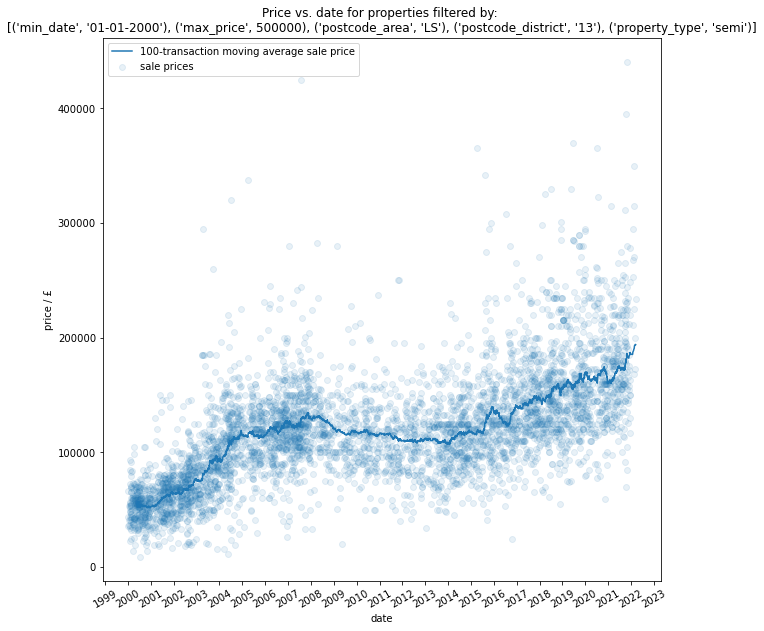

In [17]:
df_ = filter_by(dataframe=df,
                min_date='01-01-2000',
                max_price=500000,
                postcode_area='LS',
                postcode_district='13',
                property_type='semi'
               )

graph(df_)

# 6. Did certain types of houses (e.g. 3-bed semis in average areas) undergo larger price changes than other types?

I had a subjective sense that certain types of houses (semi-detached in "ok" areas) had increased in price more than others (e.g. detached 3-beds in New Farnley). 

In [30]:
df_ = filter_by(dataframe=df, min_date='01-02-2020')['dataframe']

Choose a meaningful set of parameters by which to define the groupings

In [31]:
# choose meaningful, sensible parameters by which to put properties into groups
# (example group: semi-detached newbuild freehold houses in LS6 2xx)
#grouping = ['property_type', 'newbuild', 'tenure', 'postcode_area', 'postcode_district', 'postcode_sector']
grouping = ['property_type', 'newbuild', 'tenure', 'postcode']

# self-join on the property_grouping column to get all pairwise comparisons among the groups
df_ = df_.merge(df_, on=grouping)

In [32]:
# make column names more intuitive
df_.rename(columns={'date_x': 'date_final',
                    'date_y': 'date_init',
                    'price_y': 'price_init',
                    'price_x': 'price_final',
                   },
           inplace=True)

# discard redundant pairings and self-pairings (i.e. take only upper triangular elements of pairing matrix)
df_ = df_[df_['date_final'] > df_['date_init'] ] 

# calculate price differences between property pairings
df_['price_diff'] = df_['price_final'] - df_['price_init']

# calculate date differences and convert time difference from nanoseconds to days
df_['date_diff'] = df_['date_final'] - df_['date_init']
df_['date_diff'] = df_['date_diff'].astype(int) // (86400*10**9)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


To get meaningful handle on price changes across different timeframes, it's necessary to normalise by the absolute price and the time period over which said price changes occurred:

In [33]:
df_['percent_price_change_per_day'] = (df_['price_diff'] / df_['price_init']) / (df_['date_diff'])

In [34]:
# discard superfluous columns
columns_to_keep = grouping + ['paon_x', 'paon_y', 'saon_x', 'saon_y', 'price_diff', 'date_diff', 'date_final', 'date_init', 'price_init', 'price_final', 'percent_price_change_per_day']
df_ = df_[columns_to_keep]

# make grouping column for convenience
#df_['grouping'] = df_['property_type'] + '-' + df_['newbuild'] + '-' + df_['tenure'] + '-' + df_['postcode_area'] + '-' + df_['postcode_district'] + '-' + df_['postcode_sector']
df_['grouping'] = df_['property_type'] + '-' + df_['newbuild'] + '-' + df_['tenure'] + '-' + df_['postcode']

# inspect dataframe
df_

,property_type,newbuild,tenure,postcode,paon_x,paon_y,saon_x,saon_y,price_diff,date_diff,date_final,date_init,price_init,price_final,percent_price_change_per_day,grouping
4,semi,oldbuild,freehold,LS10 3UP,23,19,,,20000,119,2020-04-30,2020-01-02,125000,145000,0.001345,semi-oldbuild-freehold-LS10 3UP
8,semi,oldbuild,freehold,LS10 3UP,3,19,,,0,419,2021-02-24,2020-01-02,125000,125000,0.000000,semi-oldbuild-freehold-LS10 3UP
9,semi,oldbuild,freehold,LS10 3UP,3,23,,,-20000,300,2021-02-24,2020-04-30,145000,125000,-0.000460,semi-oldbuild-freehold-LS10 3UP
12,semi,oldbuild,freehold,LS10 3UP,2,19,,,15000,524,2021-06-09,2020-01-02,125000,140000,0.000229,semi-oldbuild-freehold-LS10 3UP
13,semi,oldbuild,freehold,LS10 3UP,2,23,,,-5000,405,2021-06-09,2020-04-30,145000,140000,-0.000085,semi-oldbuild-freehold-LS10 3UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109022,terraced,oldbuild,freehold,LS15 7LA,74,76,,,-45500,59,2022-02-14,2021-12-17,187500,142000,-0.004113,terraced-oldbuild-freehold-LS15 7LA
109080,semi,oldbuild,freehold,LS8 5HS,67,67,,,-11750,63,2022-03-17,2022-01-13,110750,99000,-0.001684,semi-oldbuild-freehold-LS8 5HS
109174,semi,oldbuild,freehold,LS6 2BD,9,7,,,9500,10,2022-02-14,2022-02-04,275500,285000,0.003448,semi-oldbuild-freehold-LS6 2BD
109208,semi,oldbuild,freehold,LS13 1JA,108,120,,,35000,14,2022-02-25,2022-02-11,315000,350000,0.007937,semi-oldbuild-freehold-LS13 1JA


The chosen grouping parameters results in the following unique groups:

In [35]:
groups = df_.groupby(grouping).size().reset_index().rename(columns={0: 'num_pairwise_comparisons'})
groups

,property_type,newbuild,tenure,postcode,num_pairwise_comparisons
0,detached,newbuild,freehold,LS14 1FL,6
1,detached,newbuild,freehold,LS14 1FN,15
2,detached,newbuild,freehold,LS14 1FR,1
3,detached,newbuild,freehold,LS14 1FS,5
4,detached,newbuild,freehold,LS14 1FT,164
...,...,...,...,...,...
4825,terraced,oldbuild,leasehold,LS14 2EY,2
4826,terraced,oldbuild,leasehold,LS19 7JU,1
4827,terraced,oldbuild,leasehold,LS19 7YH,1
4828,terraced,oldbuild,leasehold,LS20 8FG,3


## Create a set of price windows to include as a parameter in a grid search:

In [36]:
def get_price_windows(array):
    
    # find all possible contiguous subarrays
    contiguous_subarrays = [price_grid[i:i+j] for i in range(0,len(price_grid)) for j in range(1,len(price_grid)-i+1)]

    # remove those subarrays only consisting of one element
    for element in contiguous_subarrays:
        if len(element) < 2:
            contiguous_subarrays.remove(element)
    
    # remove all but the first (lowest) and last (largest) values to get the price ranges
    price_windows = []
    for element in contiguous_subarrays:
        price_windows.append([element[0], element[-1]])
    
    return price_windows


price_grid = list(range(0, 500000, 10000))
price_windows = get_price_windows(price_grid)

In [37]:
from itertools import combinations

group_pairings = list(combinations(df_['grouping'].unique(), r=2))

In [41]:
group_pairings[:10]

[('semi-oldbuild-freehold-LS10 3UP', 'terraced-newbuild-leasehold-LS9 8FU'),
 ('semi-oldbuild-freehold-LS10 3UP', 'terraced-oldbuild-freehold-LS27 8RG'),
 ('semi-oldbuild-freehold-LS10 3UP', 'semi-oldbuild-freehold-LS17 8PZ'),
 ('semi-oldbuild-freehold-LS10 3UP', 'semi-oldbuild-freehold-LS18 5JZ'),
 ('semi-oldbuild-freehold-LS10 3UP', 'terraced-oldbuild-freehold-LS4 2QX'),
 ('semi-oldbuild-freehold-LS10 3UP', 'semi-oldbuild-freehold-LS17 7NN'),
 ('semi-oldbuild-freehold-LS10 3UP', 'detached-oldbuild-freehold-LS12 5QB'),
 ('semi-oldbuild-freehold-LS10 3UP', 'semi-oldbuild-freehold-LS7 2LX'),
 ('semi-oldbuild-freehold-LS10 3UP', 'terraced-oldbuild-freehold-LS16 5RX'),
 ('semi-oldbuild-freehold-LS10 3UP', 'terraced-oldbuild-freehold-LS4 2QS')]

In [38]:
len(group_pairings)

11662035

In [39]:
df_

,property_type,newbuild,tenure,postcode,paon_x,paon_y,saon_x,saon_y,price_diff,date_diff,date_final,date_init,price_init,price_final,percent_price_change_per_day,grouping
4,semi,oldbuild,freehold,LS10 3UP,23,19,,,20000,119,2020-04-30,2020-01-02,125000,145000,0.001345,semi-oldbuild-freehold-LS10 3UP
8,semi,oldbuild,freehold,LS10 3UP,3,19,,,0,419,2021-02-24,2020-01-02,125000,125000,0.000000,semi-oldbuild-freehold-LS10 3UP
9,semi,oldbuild,freehold,LS10 3UP,3,23,,,-20000,300,2021-02-24,2020-04-30,145000,125000,-0.000460,semi-oldbuild-freehold-LS10 3UP
12,semi,oldbuild,freehold,LS10 3UP,2,19,,,15000,524,2021-06-09,2020-01-02,125000,140000,0.000229,semi-oldbuild-freehold-LS10 3UP
13,semi,oldbuild,freehold,LS10 3UP,2,23,,,-5000,405,2021-06-09,2020-04-30,145000,140000,-0.000085,semi-oldbuild-freehold-LS10 3UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109022,terraced,oldbuild,freehold,LS15 7LA,74,76,,,-45500,59,2022-02-14,2021-12-17,187500,142000,-0.004113,terraced-oldbuild-freehold-LS15 7LA
109080,semi,oldbuild,freehold,LS8 5HS,67,67,,,-11750,63,2022-03-17,2022-01-13,110750,99000,-0.001684,semi-oldbuild-freehold-LS8 5HS
109174,semi,oldbuild,freehold,LS6 2BD,9,7,,,9500,10,2022-02-14,2022-02-04,275500,285000,0.003448,semi-oldbuild-freehold-LS6 2BD
109208,semi,oldbuild,freehold,LS13 1JA,108,120,,,35000,14,2022-02-25,2022-02-11,315000,350000,0.007937,semi-oldbuild-freehold-LS13 1JA


In [343]:
group_pairs_df = pd.DataFrame(columns=['group_x', 'group_y', 'hyp_test', 'pvalue', 'group_x_mean_percent_price_change_per_day', 'group_y_mean_percent_price_change_per_day', 'meanprice_x', 'meanprice_y'])

from datetime import datetime

from scipy import stats

print(datetime.now().strftime("%H:%M:%S"))
product=1
counter=0

for group_pairing in group_pairings[:100]:
    #print(group_pairing)

    
    vals0 = df_[df_['grouping'] == group_pairing[0]]['percent_price_change_per_day'].values
    vals1 = df_[df_['grouping'] == group_pairing[1]]['percent_price_change_per_day'].values

    
    meanprice0 = df_[df_['grouping'] == group_pairing[0]]['price_final'].values.mean()
    meanprice1 = df_[df_['grouping'] == group_pairing[1]]['price_final'].values.mean()
    
    pvalue = stats.mannwhitneyu(vals0, vals1).pvalue
    
        #print(group_pairing[0], group_pairing[1], stats.mannwhitneyu(vals0, vals1).pvalue)
    
    group_pairs_df.loc[len(group_pairs_df)] = [group_pairing[0],
                                               group_pairing[1],
                                               'mannwhitneyu',
                                               float(pvalue),
                                               vals0.mean(),
                                               vals1.mean(),
                                               meanprice0,
                                               meanprice1
                                               ]
    
    counter+=1
    if counter % 100 == 0:
        print(counter)
        print(datetime.now().strftime("%H:%M:%S"))
     #product = product*len(df_[param].unique())
    
#print(product, 'unique combinations')

21:41:02


In [342]:
df_[df_['grouping'] == group_pairing[0]]['price_final'].values.mean()

158224.61284422316

In [344]:
#group_pairs_df['pvalue'] = group_pairs_df['pvalue'].astype(float)
group_pairs_df

,group_x,group_y,hyp_test,pvalue,group_x_mean_percent_price_change_per_day,group_y_mean_percent_price_change_per_day,meanprice_x,meanprice_y
0,semi-oldbuild-freehold-LS-10-3,terraced-newbuild-leasehold-LS-9-8,mannwhitneyu,9.118331e-01,0.001071,0.000287,158224.612844,394437.037037
1,semi-oldbuild-freehold-LS-10-3,terraced-oldbuild-freehold-LS-27-8,mannwhitneyu,7.772430e-04,0.001071,0.001090,158224.612844,131880.176137
2,semi-oldbuild-freehold-LS-10-3,detached-oldbuild-freehold-LS-25-6,mannwhitneyu,5.538517e-04,0.001071,0.001813,158224.612844,309462.729968
3,semi-oldbuild-freehold-LS-10-3,other-oldbuild-leasehold-LS-17-6,mannwhitneyu,3.634188e-01,0.001071,0.051879,158224.612844,181000.000000
4,semi-oldbuild-freehold-LS-10-3,semi-oldbuild-freehold-LS-17-8,mannwhitneyu,2.841812e-04,0.001071,0.000625,158224.612844,306054.299169
5,semi-oldbuild-freehold-LS-10-3,semi-oldbuild-freehold-LS-18-5,mannwhitneyu,8.751197e-01,0.001071,0.002645,158224.612844,358962.675362
6,semi-oldbuild-freehold-LS-10-3,terraced-oldbuild-freehold-LS-4-2,mannwhitneyu,5.032914e-07,0.001071,0.001463,158224.612844,196010.863876
7,semi-oldbuild-freehold-LS-10-3,semi-oldbuild-freehold-LS-17-7,mannwhitneyu,1.825686e-03,0.001071,0.001850,158224.612844,341102.726379
8,semi-oldbuild-freehold-LS-10-3,detached-oldbuild-freehold-LS-12-5,mannwhitneyu,1.458456e-02,0.001071,0.003521,158224.612844,310555.412371
9,semi-oldbuild-freehold-LS-10-3,semi-oldbuild-freehold-LS-7-2,mannwhitneyu,7.168724e-06,0.001071,0.000998,158224.612844,271860.304712


In [317]:
datetime.now().strftime("%H:%M:%S")

'21:20:33'

In [36]:
print(len(df_['property_type'].unique()))
print(len(df_['postcode'].unique()))

print(len(df_['property_type'].unique()) *len(df_['postcode'].unique()))

5
4199
20995


In [ ]:
df_

"\n    Plots price vs. date using filtered dataframe \n    Takes dictionary with keys 'dataframe' and 'filters' output by filter_by()\n    \n    \n    dataframe = dataframe_and_filters['dataframe'] \n    filters = dataframe_and_filters['filters'] \n    \n    fig, ax = plt.subplots(1, 1)\n    fig.set_figheight(10)\n    fig.set_figwidth(10)\n    \n    # moving price average\n    dataframe['moving_average_price'] = dataframe['price'].rolling(window=100).mean()\n    \n    ax.xaxis.set_major_locator(MonthLocator(bymonth=1))\n    ax.tick_params(axis='x', labelrotation=30)\n    \n    ax.set_xlabel('date')\n    ax.set_title(f'Price vs. date for properties filtered by: \n{[(key, value) for (key, value) in filters.items()]}')\n    ax.set_ylabel('price / £')\n    \n    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.1, label='sale prices')\n    ax.plot(dataframe['date'], dataframe['moving_average_price'], label='100-transaction moving average sale price')\n    ax.legend()\n    \n"

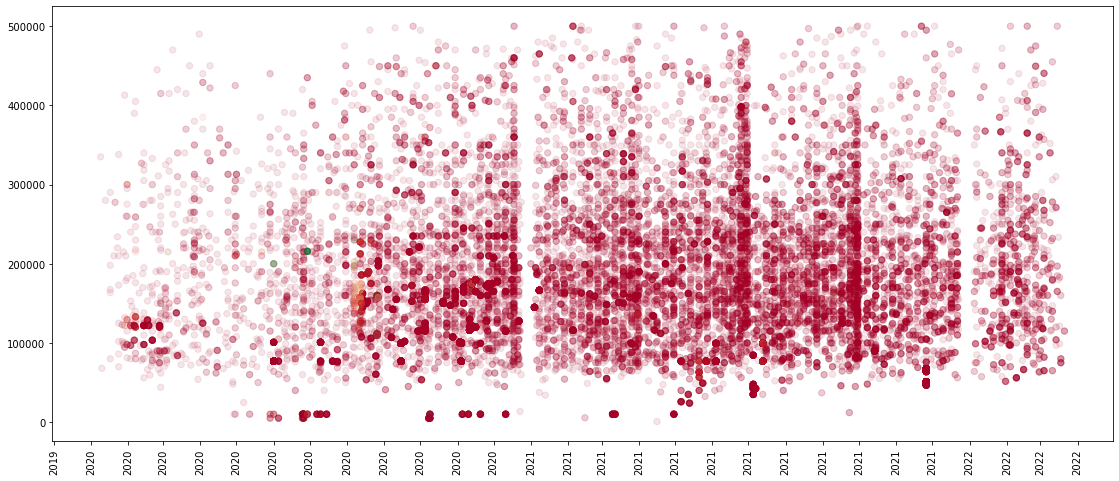

In [37]:
from matplotlib.dates import MonthLocator
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

#plt.figure(figsize=(20,20))

fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(19)

ax.tick_params(axis='x', labelrotation=90)

y = df_['price_final'].values
x = df_['date_final'].values

rdylgn = cm.get_cmap('RdYlGn', 100)
color = rdylgn(df_['percent_price_change_per_day'].values)

#norm = mpl.colors.Normalize(vmin=-0.01, vmax=0.01)
#cmap=cm.hot
#m = cm.ScalarMappable(norm=norm, cmap=cmap)
#print(m.to_rgba(x))

#color = cm.hot(df_['pc_rise_rate_scaled'].values)

ax.xaxis.set_major_locator(MonthLocator(bymonth=[1,2,3,4,5,6,7,8,9,10,11,12]))  #bymonth=1
ax.scatter(x, y, c=color, sizes=[40], alpha=0.1)
#ax.set_ylim([-0.01, 0.01])


"""
    Plots price vs. date using filtered dataframe 
    Takes dictionary with keys 'dataframe' and 'filters' output by filter_by()
    
    
    dataframe = dataframe_and_filters['dataframe'] 
    filters = dataframe_and_filters['filters'] 
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    # moving price average
    dataframe['moving_average_price'] = dataframe['price'].rolling(window=100).mean()
    
    ax.xaxis.set_major_locator(MonthLocator(bymonth=1))
    ax.tick_params(axis='x', labelrotation=30)
    
    ax.set_xlabel('date')
    ax.set_title(f'Price vs. date for properties filtered by: \n{[(key, value) for (key, value) in filters.items()]}')
    ax.set_ylabel('price / £')
    
    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.1, label='sale prices')
    ax.plot(dataframe['date'], dataframe['moving_average_price'], label='100-transaction moving average sale price')
    ax.legend()
    
"""

In [ ]:
df_['pc_rise_rate_scaled'] = df_['pc_rise_rate'].apply(lambda x: ((x*100)))
print(df_['pc_rise_rate_scaled'].max())
print(df_['pc_rise_rate_scaled'].min())
plt.hist(df_['pc_rise_rate_scaled'].values, bins=np.arange(-0.5, 0.5, 0.01))

In [ ]:
rdylgn(0)

In [ ]:
color.min()

In [ ]:
semi_ls13 = df_[df_['property_type'] == 'semi']
deta_ls13 = df_[df_['property_type'] == 'detached']

In [ ]:
semi_ls13['price_frac_change'] = semi_ls13['price_diff'] / semi_ls13['price_init']
deta_ls13['price_frac_change'] = deta_ls13['price_diff'] / deta_ls13['price_init']

In [ ]:
deta_ls13 = deta_ls13[deta_ls13['date_diff'] < 1000]
semi_ls13 = semi_ls13[semi_ls13['date_diff'] < 1000]

In [ ]:
semi_ls13['test'] = semi_ls13['date_final'] - datetime.today()

In [ ]:
semi_ls13['days_ago'] = semi_ls13['date_final'].apply(lambda x: (datetime.today() - x).days)
semi_ls13_recent = semi_ls13[semi_ls13['days_ago'] < 1000]

In [ ]:
semi_ls13_recent

In [ ]:
semi_ls13_recent ['days_ago'].values

In [ ]:
#df_s['price_diff'] = df_s['price_x'] - df_s['price_y']
#df_s['date_diff'] = df_s['date_x'] - df_s['date_y']

## there are 86400 * 10^9 nanoseconds in a day
#df_s['date_diff'] = df_s['date_diff'].astype(int) // (86400*10**9)

In [ ]:
#!pip install ipympl

### Inspect histogram of percent price change per day for all transaction pairings in groups

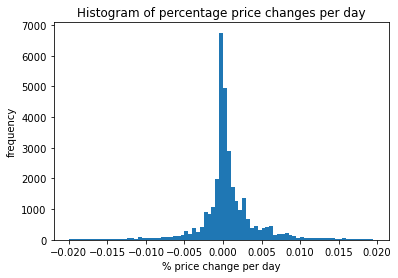

In [219]:
plt.hist(df_['percent_price_change_per_day'].values, bins=np.arange(-0.02, 0.02, 0.0005))
plt.xlabel('% price change per day')
plt.ylabel('frequency')
plt.title('Histogram of percentage price changes per day')
plt.show()

There's no obvious a-priori reason to assume this distribution is Gaussian, but assuming so gives quick and dirty measure of the distribution's spread and mean:

In [118]:
print('mean: ', round(df_['percent_price_change_per_day'].values.mean(), 4), '% price change per day')
print('std dev: ', round(df_['percent_price_change_per_day'].values.std(), 4), '% price change per day')

mean:  0.0053 % price change per day
std dev:  0.1512 % price change per day


https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93

In [212]:
stats.shapiro(df_['percent_price_change_per_day'].values)

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.02644646167755127, pvalue=0.0)

In [225]:
stats.cauchy(df_['percent_price_change_per_day'].values)

scipy.stats._distn_infrastructure.rv_frozen

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


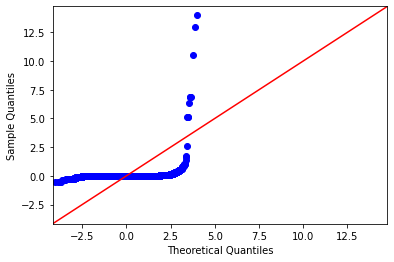

In [231]:
import statsmodels.api as sm
#from scipy.stats import norm
import pylab

my_data = df_['percent_price_change_per_day'].values
sm.qqplot(my_data, line='45')
pylab.show()

In [217]:
from scipy.stats import kstest, norm
my_data = df_['percent_price_change_per_day'].values
ks_statistic, p_value = kstest(my_data, 'norm')
print(ks_statistic, p_value)

0.47589979837950996 0.0


In [ ]:
"""
price_diff
price_y (initial price)
time_diff

"""

In [ ]:
#df_s['date_diff']

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(semi_ls13_recent['price_final'], semi_ls13_recent['price_frac_change'])
#plt.scatter(deta_ls13['price_final'], deta_ls13['price_frac_change'])
plt.legend()
#plt.plot(t['date'], t['price'])

In [ ]:
from matplotlib.dates import MonthLocator

def graph2(dataframe):
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    # moving price average
    dataframe['MA'] = dataframe['price'].rolling(window=30).mean()
    
    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.2)
    ax.xaxis.set_major_locator(MonthLocator())  #bymonth=1
    ax.tick_params(axis='x', labelrotation=90)
    ax.plot(dataframe['date'], dataframe['MA'])

graph2(df_)

## Price changes as a function of price

In [ ]:
# old plotting function

def graph(postcode, housetype, streetname, ):

    postcode_type = df[  (df['postcode_area'] == f'{postcode}') & (df['type'] == f'{housetype}') ]
    
    # df for individual street
    street = postcode_type[postcode_type['street'] == f'{streetname}']
    
    # price data for street
    street_price = street.groupby(by=['months_ago']).agg({'price': 'median'})
    
    # moving average for street
    street_price['MA'] = street_price['price'].rolling(window=12).mean()
    
    # price data for postcode area
    postcode_type_price = postcode_type.groupby(by=['months_ago']).agg({'price': 'median'})
    postcode_type_price = postcode_type_price.groupby(by=['months_ago']).agg({'price': 'median'})
    
    # moving average for postcode area
    postcode_type_price['MA'] = postcode_type_price['price'].rolling(window=12).mean()
    
    plt.plot(street_price.index, street_price['price'].values,c='red',  label=f'{streetname}')
    plt.plot(street_price.index, street_price['MA'].values, c='pink',  label=f'{streetname} moving average')
    
    plt.plot(postcode_type_price.index, postcode_type_price['MA'].values ,c='green',  label=f'{postcode, housetype} moving average')
    plt.scatter(postcode_type_price.index, postcode_type_price['price'].values, c='blue', label=f'{postcode, housetype}')
    
    plt.rcParams["figure.figsize"]=(20,20)
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.show()


In [ ]:
# choose leeds
leeds = filter_by(df, pc_area='LS')

In [ ]:
# filter by timescales spanning the beginning of Covid to present
leeds = leeds[(leeds['date'] > '2019-10-01')]

In [ ]:
leeds

In [ ]:
t = leeds['date'].max() -  leeds['date'].min()

In [ ]:
from dateutil import relativedelta

def get_months_difference(timestamp1, timestamp2):
    
    r = relativedelta.relativedelta(timestamp1, timestamp2)

    months_diff = (r.years * 12) + r.months
    
    return months_diff

In [ ]:
leeds['months_ago'] = leeds['date'].apply(lambda x: get_months_difference(datetime.today(), x))

In [ ]:
datetime.today() - leeds['date'].max()

In [ ]:
leeds

In [ ]:
leeds[leeds['months_ago'] == 2]['price'].mean()

In [ ]:
leeds[leeds['months_ago'] == 28]['price'].mean()

In [ ]:
leeds['mean_price'] = leeds['months_ago'].apply(lambda x: leeds[leeds['months_ago'] == x]['price'].mean())

In [ ]:
leeds

In [ ]:
leeds['price_diff'] = leeds['price'] - leeds['mean_price']

In [ ]:
leeds['price_ratio'] = leeds['price'] / leeds['mean_price']

In [ ]:
test = leeds[leeds['months_ago'] == 28]

plt.scatter(test['price'], test['price_diff'])
     
plt.rcParams["figure.figsize"]=(20,20)
plt.xticks(rotation=90)
#plt.xlim(0, 500000)
#plt.ylim(-1, 100000)

plt.show()

In [ ]:
#for r in t_adj.index:
#    for c in t_adj.index:
#        t_adj.at[r, c] = t['price'].loc[c] - t['price'].loc[r] if t['date'].loc[c] > t['date'].loc[r] else np.nan

In [ ]:
#df.groupby(['property'], as_index=False)[['price' , 'date']].sum()
#df.groupby(['property'])
#df

#df = df[df['property_type'] != 'other']

# df['newbuild'] = df['newbuild'].apply(lambda x: 'newbuild' if x=='Y' else ('oldbuild' if x=='N' else x))
# df['tenure'] = df['tenure'].apply(lambda x: 'freehold' if x=='F' else('leasehold' if x=='L' else 'unknown'))
# df['property_type'] = df['property_type'].apply(lambda x: 'detached' if x=='D' else ('semi' if x=='S' else('terraced' if x=='T' else ('flat' if x=='F' else 'other'))))

#df['tenure'].value_counts()

In [ ]:
#df.plot(x='date', y='price')
#plt.show()

In [ ]:
# df = df.sort_values('date')
# 
# df['street'] = df['street'].astype(str)
# df['street'] = df['street'].apply(lambda x: x.lower())
# 
# df['days_ago'] = df['date'].apply(lambda x: datetime.today() - datetime.strptime(x, '%Y-%m-%d'))
# df['days_ago'] = df['days_ago'].apply(lambda x: str(x).split(' ')[0])
# df['days_ago'] = df['days_ago'].apply(lambda x: -int(x))
# df['months_ago'] = df['days_ago'].apply(lambda x: int(round( x/(365/12) ,0) ))

In [ ]:
# def graph(postcode, housetype, streetname):
# 
#     import matplotlib.pyplot as plt
# 
#     postcode_type = df[  (df['postcode_area'] == f'{postcode}') & (df['type'] == f'{housetype}') ]
#     
#     # df for individual street
#     street = postcode_type[postcode_type['street'] == f'{streetname}']
#     
#     # price data for street
#     street_price = street.groupby(by=['months_ago']).agg({'price': 'median'})
#     
#     # moving average for street
#     street_price['MA'] = street_price['price'].rolling(window=12).mean()
#     
#     # price data for postcode area
#     postcode_type_price = postcode_type.groupby(by=['months_ago']).agg({'price': 'median'})
#     postcode_type_price = postcode_type_price.groupby(by=['months_ago']).agg({'price': 'median'})
#     
#     # moving average for postcode area
#     postcode_type_price['MA'] = postcode_type_price['price'].rolling(window=12).mean()
#     
#     plt.plot(street_price.index, street_price['price'].values,c='red',  label=f'{streetname}')
#     plt.plot(street_price.index, street_price['MA'].values, c='pink',  label=f'{streetname} moving average')
#     
#     plt.plot(postcode_type_price.index, postcode_type_price['MA'].values ,c='green',  label=f'{postcode, housetype} moving average')
#     plt.scatter(postcode_type_price.index, postcode_type_price['price'].values, c='blue', label=f'{postcode, housetype}')
#     
#     plt.rcParams["figure.figsize"]=(20,20)
#     plt.xticks(rotation=90)
#     plt.legend(loc='best')
#     plt.show()

In [ ]:
def mortgage(principal, total_period, init_period, init_payment, init_rate, subs_rate, base_rate, over_payment):
    
    """
    Mortgage payment calculator. Returns dictionary of arrays
    
    principal: amount borrowed in arbitrary currency, e.g. 500000
    total_period: total mortgage duration in months
    init_period: initial term duration in months
    init_payment: initial monthly payment amount, e.g. 1205
    init_rate: initial interest rate expressed as a decimal. e.g. 0.0146 for 1.46%
    subs_rate: subsequent interest rate expressed as a decimal. e.g. 0.0376 for 3.76%
    base_rate: Bank of England base rate. e.g. 0.001 for 0.1%
    over_payment: optional fixed monthly overpayment
    """    
    
    # create arrays for plotting
    interest_values = []
    payment_values = []
    over_payment_values = []
    principal_values = []
    interest_cum_values = []
   
    # calculate initial max overpayment
    max_monthly_overpayment = principal*0.1*(1/12)
    
    # cumulative interest
    interest_cum = 0
    
    # payments for months of initial period
    for month in range(0, init_period):
        
        # update max available monthly overpayment each year
        if month % 12 == 0:
            max_monthly_overpayment = principal*0.1*(1/12)
            
        # calculate interest
        interest = principal*(1 + init_rate)**(1/12) - principal
        
        # add to interest for this month to total interest charged
        interest_cum += interest
    
        # add interest for current month
        principal += interest
     
        # subtract payment amount from principal
        if principal < init_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= init_payment       
            
        # subtract overpayment from principal
        if over_payment > max_monthly_overpayment:
            over_payment = max_monthly_overpayment

            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
        else:
            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
   
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(init_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
   
    # calculate payments for remaining balance at new rate
    subs_payment = ((((subs_rate+base_rate)/12))*((1+((subs_rate+base_rate)/12))**(total_period-init_period)) / (((1+((subs_rate+base_rate)/12))**(total_period-init_period)) - 1))*(principal)
    
    # payments for subsequent months
    for month in range(init_period, total_period):
        
        # interest added
        interest = principal*(1 + (subs_rate+base_rate))**(1/12) - principal
        
        # add to cumulative interest 
        interest_cum += interest
            
        # add interest for current month
        principal += interest
    
        # subtract (minimum) payment amount from principal
        if principal < subs_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= subs_payment
            
        # subtract overpayment amount from principal
        if principal < over_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0

        else:
            principal -= over_payment
        
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(subs_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
        
    results = dict.fromkeys(['Interest', 'Payments', 'Overpayments', 'Principal'])
    results['Interest'] = interest_values
    results['Payments'] = payment_values
    results['Overpayments'] = over_payment_values
    results['Principal'] = principal_values
    
    return results